# Second Hands-On Session
--- 
Tracking many particles - Twiss parameters

---

## 🐍 Python corner

We'll be using:
- `numpy` as `np`
- `matplotlib.pyplot` as `plt`
- functions `D`

In [12]:
from tracking_library import *

## 📝 Exercise 2.1 (guided): Generating an ensemble of particles <a id="exercise-2.1-guided"></a>

Define an ensemble of 100 particles with arbitrary first order (e.g. $<x_0> = 0.2$ mm, $<x'_0> = 1$ mrad) and second order (e.g. $\sigma_{x_0} = 1.5$ mm and $\sigma_{x'_0} = 0.5$ mrad) momenta.
Verify that the angular divergence of the beam is the one set: 

- What do you observe?
- What happens if you increase or decrease the number of particles?

> 👀 **HINT**: Remember that you can create a Normal distributed 2xN 2D array of numbers as `np.random.randn(2, N)`. One can then "stretch" and "offset" (and eventually "rotate", but this is not requested here) this distribution to obtain any desired 2D normal distribution in phase space.

In [13]:
# simple solution
N_particles = 100
beam = np.array([ np.random.randn(N_particles), 
                  np.random.randn(N_particles) ])
# or equivalently:
beam = np.random.randn(2, N_particles)
x0 = 0.2
xp0 = 1
sigx = 1.5
sigxp = 0.5
beam[0, :] = sigx * beam[0, :] + x0
beam[1, :] = sigxp * beam[1, :] + xp0
print(f"Beam mean  x [mm]: {np.mean(beam[0,:])}")
print(f"Beam mean  x' [mrad]: {np.mean(beam[1,:])}")
print(f"Beam rms size [mm]: {np.std(beam[0,:])}")
print(f"Beam rms divergence [mrad]: {np.std(beam[1,:])}")

Beam mean  x [mm]: 0.3718270408891029
Beam mean  x' [mrad]: 0.8914040491252464
Beam rms size [mm]: 1.5005130302800458
Beam rms divergence [mrad]: 0.47189905123962866


❓**QUESTION: Why didn't we find back the input parameters?**

## 📝 Exercise 2.2: Tracking an ensemble of particles in a drift <a id="exercise-2.2"></a>

1. Transport the beam distribution of [Exercise 2.1](#exercise-2.1-guided) in a drift of length 1 m. Visualise the initial and final distribution. **What do you observe?**

   > 👀 **HINT 1**: the output of `transportParticles` contains the coordinates of all particles at all locations. To obtain all particle coordinates at the end of the beamline, you can simply do:
   >
   > ```
   > tracked = transportParticles(initial_coordinates, beamline)
   > final_coordinates = tracked['coords'][-1] #where "-1" refers to the last element of the beamline
   > ```

   > 👀 **HINT 2**: One can use `plt.plot` or `plt.scatter` to plot the 2D distribution, e.g.:
   > ```
   > plt.scatter(x, xp, marker='.')
   > ```

2. (Optional) Test of linearity. Scale the input vector by 17 times the month of your birthday (e.g. 85 if you are born in May) and verify that the output vector from the matrix multiplication has changed by the same factor.
    
    > 👀 **HINT**: Be careful with machine precision!


### Solution for 1.

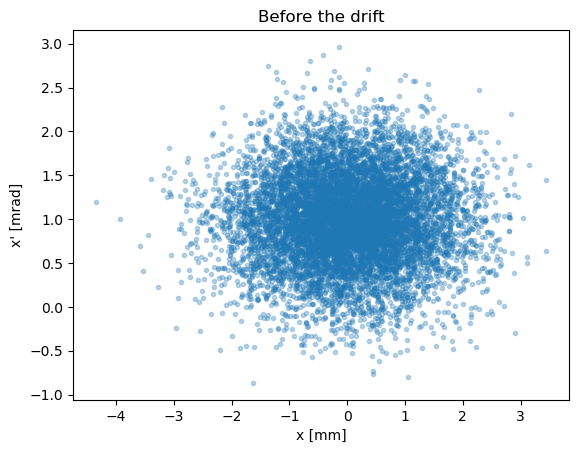

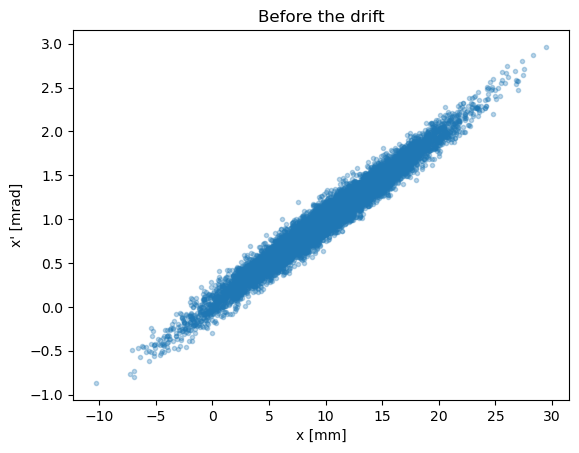

In [14]:
# Generate particle coordinates
n_part = 10000
beam = np.random.randn(2, n_part)
x0 = 0
xp0 = 1
sigx = 1
sigxp = 0.5
beam[0, :] = sigx * beam[0, :] + x0
beam[1, :] = sigxp * beam[1, :] + xp0

# Trasport particles
tracked = transportParticles(np.array(beam), D(10))
beam_after_drift = tracked["coords"][-1]  # where "-1" refers to the last element of the beamline

# Before the drift
plt.figure()
plt.xlabel("x [mm]")
plt.ylabel("x' [mrad]")
plt.title("Before the drift")
plt.scatter(beam[0, :], beam[1, :], marker='.', alpha=0.3)

# After the drift
plt.figure()
plt.xlabel("x [mm]")
plt.ylabel("x' [mrad]")
plt.title("Before the drift")
plt.scatter(beam_after_drift[0, :], beam_after_drift[1, :], marker='.', alpha=0.3)

### Solution for 2. 

In [15]:
month_birthday = 3
v1 = D(1)[0]["matrix"] @ (17 * month_birthday * beam)
v2 = 17 * month_birthday * D(1)[0]["matrix"] @ (beam)

# this might return False due to machine precision rounding - See **Computational tools** course!:
print(np.array_equal(v1, v2))
# let's compare at the level of 10 times epsilon, times the scaling factor used for the test
print(np.max(np.abs(v1 - v2)) < 10 * 17 * month_birthday * np.finfo(v1.dtype).eps)

False
True


## 📝 Exercise 2.3: Tracking an ensemble of particles along a beamline (mean position & beam size) <a id="exercise-2.3"></a>

Build a beamline made of several drift and quadrupoles as desired (e.g. `D(0.5)+Q(1)+D(2)+Q(-1)+D(1)+Q(2)+....`).

Build a beam made of several particles (e.g. 1000) again with arbitrary first order (e.g. $<x_0> = 0.2$ mm, $<x'_0> = 1$ mrad) and second order (e.g. $\sigma_{x_0} = 1.5$ mm and $\sigma_{x'_0} = 0.5$ mrad) momenta, as done in previous [Exercise 2.2](#exercise-2.2).

1. Plot the individual particle trajectories along the beamline

2. Compute and plot the average beam position, the beam size ($\sigma_x$) and divergence ($\sigma_{x'}$) along the beam line.

> 👀 **HINT 1 (Python)**: Remember that in the output of our `transportParticles` function the key `'x'` contains a 2D array with N rows (the index of the position along the beam line) and M columns (the index of a given particle). 
You can compute the standard deviation of **each raw** of a NxM 2D array as `np.std(N_times_M_array,1)`. 

> 👀 **HINT 2 (Python)**: After having plotted $x$ trajectory on a matplotlib plot, one can create a **second vertical axis** that shares the same horizontal axis with `plt.twinx()`. This can be convenient to see, for example, both $\sigma_x$ and $\sigma_{x'}$ on the same plot.


In [16]:
# prepare the beamline
beamline = 5 * (10 * D(0.5 / 10) + Q(1) + 10 * D(2 / 10) + Q(-0.8) + 10 * D(1.5 / 10) + Q(0.3) + +10 * D(1.5 / 10))

# prepare the beam
N_particles = 1000
beam = np.random.randn(2, N_particles)
x0 = 0.2
xp0 = 1
sigx = 1.5
sigxp = 0.5
beam[0, :] = sigx * beam[0, :] + x0
beam[1, :] = sigxp * beam[1, :] + xp0

### Solution for 1. 

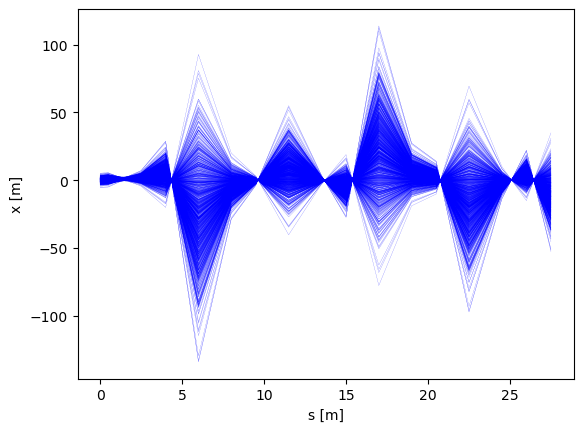

In [17]:
transported_particles = transportParticles(beam, beamline)

plt.xlabel("s [m]")
plt.ylabel("x [m]")
for i in range(N_particles):
    plt.plot(transported_particles["s"], transported_particles["x"][:,i], '-', color='blue', lw=0.1)

### Solution for 2. 

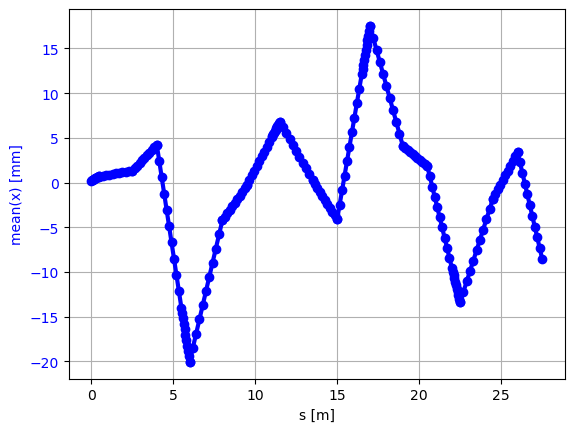

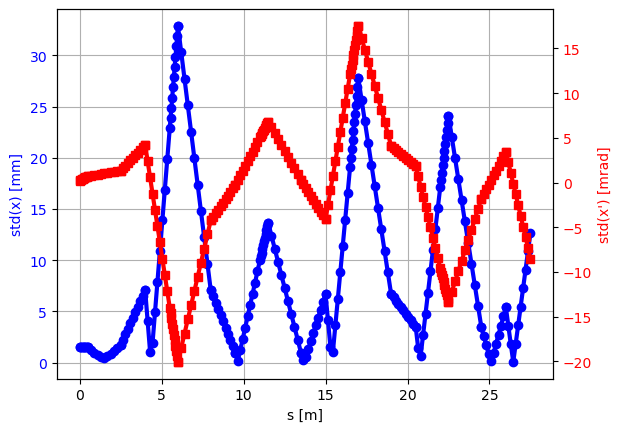

In [7]:
plt.plot(transported_particles["s"], np.mean(transported_particles["x"], 1), "o-b", lw=3)
plt.grid(True)
plt.xlabel("s [m]")
plt.ylabel("mean(x) [mm]", color="b")
plt.tick_params(axis="y", labelcolor="b")
plt.show()

plt.plot(transported_particles["s"], np.std(transported_particles["x"], 1), "o-b", lw=3)
plt.grid(True)
plt.xlabel("s [m]")
plt.ylabel("std(x) [mm]", color="b")
plt.tick_params(axis="y", labelcolor="b")

ax2 = plt.twinx()  # instantiate a second axes that shares the same x-axis
plt.ylabel("std(x') [mrad]", color="r")
plt.tick_params(axis="y", labelcolor="r")
#plt.plot(transported_particles["s"], np.std(transported_particles["xp"], 1), "s-r", lw=3)
plt.plot(transported_particles["s"], np.mean(transported_particles["x"], 1), "s-r", lw=3)

## ⚛️ Physics focus: Sigma matrices

One can easily demonstrate (see [Wolfgan's lecture](https://indico.cern.ch/event/1356988/contributions/5713241/)) that the same matrix ($M$) used for tracking the coordinates ($(x_i, x'_i)$) of each single particle ($i$) from an initial point ($X_0$) to a final point ($X_s$) in a beamline:

\begin{equation}
X_s =  M\, X_0
\end{equation}

can also be used to track the **average trajectory** ($\langle X \rangle$) as well as the **covariance or sigma matrix** of the given particle coordinates distribution:

\begin{equation}
\langle X_s \rangle = 
\left[
\begin{array}{c}
\langle x_i \rangle\\
\langle x'_i \rangle
\end{array}
\right]_s 
= M\, \langle X_0 \rangle
\end{equation}

\begin{equation}
\Sigma_s = \left[
\begin{array}{c}
\sigma_{xx}\quad \sigma_{xx'}\\
\sigma_{x'x}\quad \sigma_{x'x'}
\end{array}
\right]_s
= M\, \Sigma_0\, M^T\, .
\end{equation}

We can therefore track the **average trajectory** and **covariance** of a beam simply starting from its initial average coordinates and covariance matrix in phase space.

The "tracking" of an initial **covariance** matrix along a given beamline is provided by the function `transportSigmas()` function from our toolbox:

In [8]:
from tracking_library import transportSigmas

# let's see if there is some help information:
help(transportSigmas)

Help on function transportSigmas in module tracking_library:

transportSigmas(sigma_0, beamline)
    Transport the input sigma matrix (\sigma_{0}) along the given beamline

    It will return a dictionary containing the following key:values
        'sigma11': a N-long numpy array with the \sigma_{11} value for all N-elements of the beamline
        'sigma12': a N-long numpy array with the \sigma_{12} value for all N-elements of the beamline
        'sigma21': a N-long numpy array with the \sigma_{21} value for all N-elements of the beamline
        'sigma22': a N-long numpy array with the \sigma_{22} value for all N-elements of the beamline
        's': a N-long numpy array with the longitudinal position of the N-elements of the beamline
        'sigmas': a Nx2x2 numpy array with all sigma matrices at all N-elements of the beamline

    Disclaimer: if beamline is made of 5 elements, the output will have 5+1 "elements" as it will also
                return include the initial sigma mat

## 📝 Exercise 2.4: Tracking only the average beam position

Show that **the average position of a beam along a beam line** (e.g. the beamline and beam you defined in [Exercise 2.3](#exercise-2.3)) is the same as **the trajectory of single particle that starts in the center of the initial particle distribution**.

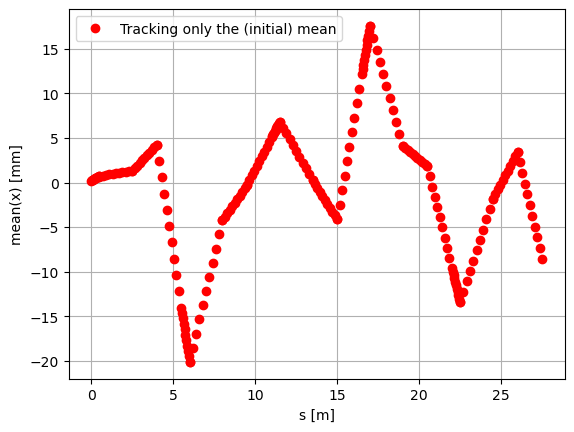

In [9]:
# As exercise 2.3
# prepare the beamline
beamline = 5 * (10 * D(0.5 / 10) + Q(1) + 10 * D(2 / 10) + Q(-0.8) + 10 * D(1.5 / 10) + Q(0.3) + +10 * D(1.5 / 10))
# prepare the beam
N_particles = 1000
beam = np.random.randn(2, N_particles)
x0 = 0.2
xp0 = 1
sigx = 1.5
sigxp = 0.5
beam[0, :] = sigx * beam[0, :] + x0
beam[1, :] = sigxp * beam[1, :] + xp0

# single particle that starts in the center of the initial particle distribution
single_particle = np.array([ [np.mean(beam[0, :])],     # average position
                             [np.mean(beam[1, :])] ])  # average divergence

# transport only the average position
transported_mean = transportParticles(single_particle, beamline)

plt.plot(transported_mean["s"], transported_mean["x"], "or", lw=3, label="Tracking only the (initial) mean")
plt.grid(True)
plt.xlabel("s [m]")
plt.ylabel("mean(x) [mm]")
plt.legend()

## 📝 Excercise 2.5: Tracking only the beam size

For the same system as before, track only the sigma matrix and compare with the rms beam size computed from tracking all particles (Exercise 2.3).

> 🔹 **NOTE**: Is this valid for any number of initially tracked particles? How does the result change if one uses the **input** covariance matrix used to generate the particle distribution rather then the **actual** covariance matrix of the generated distribution?

> 👀 **HINT 1**: Remember that the element $\sigma_{xx}$ of the covariance matrix is linked to the rms beam size ($\sigma_x$) as $\sigma_x = \sqrt{\sigma_{xx}}$.

> 👀 **HINT 2**: The covariance matrix of a 2xN array can be computed using `numpy` as `np.cov(2_times_N_array, bias=True)`.

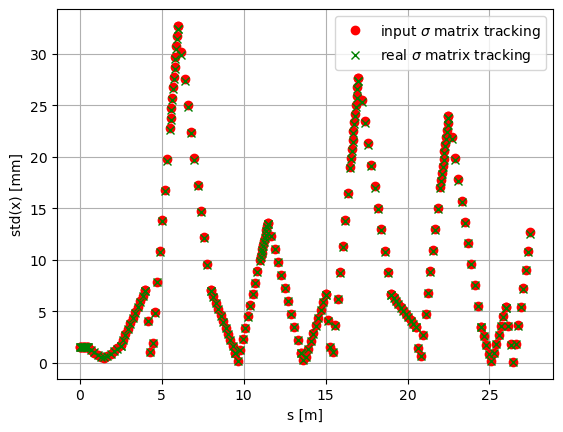

In [10]:
# As exercise 2.3
# prepare the beamline
beamline = 5 * (10 * D(0.5 / 10) + Q(1) + 10 * D(2 / 10) + Q(-0.8) + 10 * D(1.5 / 10) + Q(0.3) + +10 * D(1.5 / 10))
# prepare the beam
N_particles = 1000
beam = np.random.randn(2, N_particles)
x0 = 0.2
xp0 = 1
sigx = 1.5
sigxp = 0.5
beam[0, :] = sigx * beam[0, :] + x0
beam[1, :] = sigxp * beam[1, :] + xp0

# prepare the sigma matrix based on our inputs:
sigma_0 = np.array([ [sigx**2,        0], 
                     [0,       sigxp**2] ])
# alternative: if we use the covariance matrix of the generated distribution:
# (takes into account the small antidiagonal terms)
sigma_real = np.cov(beam, bias=True)

# transport only the average position
transported_sigmas = transportSigmas(sigma_0, beamline)
transported_real_sigmas = transportSigmas(sigma_real, beamline)

# plot all estimation of beam size:
plt.plot(transported_sigmas["s"], np.sqrt(transported_sigmas["sigma11"]), "or", lw=3, label=r"input $\sigma$ matrix tracking")
plt.plot(transported_real_sigmas["s"], np.sqrt(transported_real_sigmas["sigma11"]), "xg", lw=3, label=r"real $\sigma$ matrix tracking")
plt.grid(True)
plt.xlabel("s [m]")
plt.ylabel("std(x) [mm]")
plt.legend()

> 🔹 **NOTE**: It is important to observe that the result of from the particle tracking and the sigma matrix tracking are equivalent.
The small deviation is due to the statistical noise of the ensemble (it can be reduced by increasing the number of particles).
This deviation is zero (or numerical) if one tracks the actual covariance matrix of the ensemble of the generated particles. (Note that the `bias=True` option to numpy `cov` function is necessary to force the simple (bias) computation of the covariance)
> 
> Clearly, the sigma matrix tracking is computationally cheaper than the particle tracking (if n_part>>1).

## ⚛️ Physics focus: Introduction of Twiss values and emittance

Recall that:

\begin{equation}
\Sigma_{s} = M\, \Sigma_{0}\, M^T\, .
\end{equation}

where $M$ is a real **symplectic** transformation, and its determinant is $\det(M) = +1$. Therefore:

\begin{equation}
\det(\Sigma_s) = \det( M\, \Sigma_0\, M^T ) = \det(M) \det(\Sigma_0) \det(M^T) = \det(\Sigma_0)
\end{equation}

the determinant of the sigma/covariance matrix is **preserved** along a beamline. The sigma/covariance matrix of any particle distribution can be parameterized as:

\begin{equation}
\Sigma = 
    \left[
    \begin{array}{cc}
    \sigma_{xx}  & \sigma_{xx'}\\
    \sigma_{x'x} & \sigma_{x'x'}
    \end{array}
    \right] =
    \epsilon
    \left[ 
    \begin{array}{cc}
        \beta   & -\alpha\\
        -\alpha & \gamma
    \end{array}
    \right] 
\end{equation}

where $\beta$, $\alpha$, $\gamma$ and $\epsilon$ are parameters such that $\epsilon = \sqrt{\det(\Sigma)}$ (the beam **statistical emittance**) and $\beta \gamma - \alpha^2 = 1$. The *Twiss* parmeters $\beta, \gamma, \alpha$ define the **normalised** shape/orientation of the beam distribution in phase-space!

**This seems to be an arbitrary choice!** but it will acquire more special meaning later.

## 📝 Exercise 2.6: Equivalent matrix symplecticity
Verify that the equivalent transport matrix of any beamline, e.g. the one you used in [Exercise 2.3](#exercise-2.3), has determinant equal to 1 (within machine precision).

> 👀 **HINT (Python)**: you can use `np.linalg.det(matrix)` to compute the determinant of a matrix `matrix`

In [13]:
# lattice
beamline = 5 * (10 * D(0.5 / 10) + Q(1) + 10 * D(2 / 10) + Q(-0.8) + 10 * D(1.5 / 10) + Q(0.3) + +10 * D(1.5 / 10))

# compute equivalent matrix of the whole beamline
OTM = getEquivalentElement(beamline)
print(f'The determinant of the FODO OTM is {np.linalg.det(OTM[0]["matrix"])}.')

The determinant of the FODO OTM is 0.9999999999999054.


## 📝 Exercise 2.7: Evolution of Twiss parameters in a beamline

Consider again a beamline, e.g. the one you used in [Exercise 2.3](#exercise-2.3), and create a valid sigma matrix with:
- $\beta$ = 3 [m]
- $\gamma$ = 0.5 [1/m]
- $\epsilon$ = 5 [$\mu$ m]

Then, propagate the $\sigma$ matrix through the beam line and verify that the emittance $\epsilon$ of the sigma matrix after every element is indeed constant and equal to its initial value.

**Optional:** compute and plot the **beta** (function) all along the beamline, i.e. $\sigma_{11}/\epsilon$

> 👀 **HINT (Python)**: in the output of our `transportSigmas()` function we keep all sigma matrixes. The determinant of all matrices can be computed in one go as `np.linalg.det(transported_sigmas['sigmas'])`.

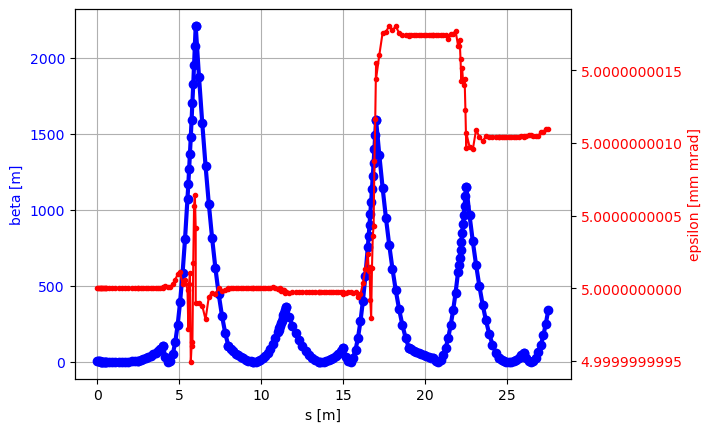

In [11]:
# lattice
beamline = 5 * (10 * D(0.5 / 10) + Q(1) + 10 * D(2 / 10) + Q(-0.8) + 10 * D(1.5 / 10) + Q(0.3) + 10 * D(1.5 / 10))

# let's create a simple sigma matrix
beta0 = 3
gamma0 = 0.5
epsilon0 = 5
# alfa must be:
alfa0 = np.sqrt(beta0 * gamma0 - 1)
sigma_0 = epsilon0 * np.array([[beta0, -alfa0], [-alfa0, gamma0]])

# transport the sigma matrix:
transported_sigmas = transportSigmas(sigma_0, beamline)

# compute the emittance as sqrt of the determinant of all sigma matrices along
# the beamline
emittance = np.sqrt(np.linalg.det(transported_sigmas["sigmas"]))
# the beta function can be extracted as well from the 'sigma11' element,
# divided by the emittance
beta = transported_sigmas["sigma11"] / emittance

# make a simple plot
plt.plot(transported_sigmas["s"], beta, "o-b", lw=3)
plt.grid(True)
plt.xlabel("s [m]")
plt.ylabel("beta [m]", color="b")
plt.tick_params(axis="y", labelcolor="b")

ax2 = plt.twinx()  # instantiate a second axes that shares the same x-axis
plt.ylabel("epsilon [mm mrad]", color="r")
plt.tick_params(axis="y", labelcolor="r")
plt.plot(transported_sigmas["s"], emittance, ".-r")
plt.ticklabel_format(useOffset=False)

## Well done !!

Now you understand how to transport an ensamble of particles or its **covariance** matrix along a beamline... But how to design a "nice" beamline?

=> **Continue your learning with the following [notebook](./03_Periodic_Systems.ipynb)**...
